# Section 1. Post processing of extracted features downloaded from HDFS

Some columns contain multiple values after running a feature extraction script, i.e. multiple percentile values. We will create a correct structure of columns and select rows for which we have ground truth.

In [2]:
#!/home/big-dama/anaconda3/bin/python
import os
import sys


os.environ["PYSPARK_PYTHON"] = "/home/big-dama/anaconda3/bin/python"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-oracle/jre"
os.environ["SPARK_HOME"] = "/opt/cloudera/parcels/SPARK2-2.4.0.cloudera2-1.cdh5.13.3.p0.1041012/lib/spark2"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
os.environ['PYSPARK_SUBMIT_ARGS'] = "--master yarn --deploy-mode client --conf spark.executor.memory=20g pyspark-shell"


import os.path
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark import sql
from pyspark.sql import Row
from pyspark.sql import SQLContext, HiveContext, DataFrameWriter
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, sum
from pyspark.sql import SparkSession
from datetime import datetime
import subprocess
import math
import time
from pyspark.sql import functions as F
from pyspark.sql.functions import lit, col, udf
from operator import add
from functools import reduce
from pyspark.sql.functions import pandas_udf, PandasUDFType
import numpy as np
from scipy.stats import entropy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# described here https://medium.com/@achilleus/spark-session-10d0d66d1d24
print("starting")
spark = SparkSession.builder\
                    .appName("darknet_feature_extraction_without_hive")\
                    .master("yarn")\
                    .config("spark.submit.deployMode","client")\
                    .config("spark.executor.memory","20g")\
                    .config("spark.driver.memory","20g")\
                    .config('spark.sql.autoBroadcastJoinThreshold','-1')\
                    .enableHiveSupport()\
                    .getOrCreate()

print("done with startup")

output_loc = '/user/big-dama/pavol/mawi_data_052016/extracted_mawi_052016_features/*'



starting
done with startup


In [ ]:
schema = StructType([StructField('file_name',DoubleType(),True)\
                    , StructField('vol(frame_len)',DoubleType(),True)\
                    , StructField('num_pkts(frame_len)',DoubleType(),True)\
                    , StructField('min(frame_len)',DoubleType(),True)\
                    , StructField('max(frame_len)',DoubleType(),True)\
                    , StructField('avg(frame_len)',DoubleType(),True)\
                    , StructField('var(frame_len)',DoubleType(),True)\
                    , StructField('stddev(frame_len)',DoubleType(),True)\
                    , StructField('percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_frame_len)',StringType(),True)\
                    , StructField('entropy(frame_len)',DoubleType(),True)\
                    , StructField('min(ip_len)',DoubleType(),True)\
                    , StructField('max(ip_len)',DoubleType(),True)\
                    , StructField('avg(ip_len)',DoubleType(),True)\
                    , StructField('var(ip_len)',DoubleType(),True)\
                    , StructField('stddev(ip_len)',DoubleType(),True)\
                    , StructField('percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_(ip_len)',StringType(),True)\
                    , StructField('entropy(ip_len)',DoubleType(),True)\
                    , StructField('min(ip_ttl)',DoubleType(),True)\
                    , StructField('max(ip_ttl)',DoubleType(),True)\
                    , StructField('avg(ip_ttl)',DoubleType(),True)\
                    , StructField('var(ip_ttl)',DoubleType(),True)\
                    , StructField('stddev(ip_ttl)',DoubleType(),True)\
                    , StructField('percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_(ip_ttl)',StringType(),True)\
                    , StructField('entropy(ip_ttl)',DoubleType(),True)\
                    , StructField('min(tcp_len)',DoubleType(),True)\
                    , StructField('max(tcp_len)',DoubleType(),True)\
                    , StructField('avg(tcp_len)',DoubleType(),True)\
                    , StructField('var(tcp_len) ',DoubleType(),True)\
                    , StructField('stddev(tcp_len)',DoubleType(),True)\
                    , StructField('percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_(tcp_len) ',StringType(),True)\
                    , StructField('entropy(tcp_len)',DoubleType(),True)\
                    , StructField('min(tcp_winsize)',DoubleType(),True)\
                    , StructField('max(tcp_winsize)',DoubleType(),True)\
                    , StructField('avg(tcp_winsize)',DoubleType(),True)\
                    , StructField('var(tcp_winsize)',DoubleType(),True)\
                    , StructField('stddev(tcp_winsize)',DoubleType(),True)\
                    , StructField('percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_(tcp_winsize)',StringType(),True)\
                    , StructField('entropy(tcp_winsize)',DoubleType(),True)\
                    , StructField('entropy(tcp_flags)',DoubleType(),True)\
                    , StructField('frac_ipv4',DoubleType(),True)\
                    , StructField('frac_ipv6',DoubleType(),True)\
                    , StructField('frac_icmp_tcp_udp_gre(ip_proto)',StringType(),True)\
                    , StructField('num_icmp_tcp_udp_gre(ip_proto)',StringType(),True)\
                    , StructField('num_appport_ranges(tcp_dstport)',DoubleType(),True)\
                    , StructField('frac_appport_ranges(tcp_dstport)',DoubleType(),True)\
                    , StructField('num_appport_ranges(tcp_srcport)',DoubleType(),True)\
                    , StructField('frac_appport_ranges(tcp_srcport)',DoubleType(),True)\
                    , StructField('num_appport_ranges(udp_dstport)',DoubleType(),True)\
                    , StructField('frac_appport_ranges(udp_dstport)',DoubleType(),True)\
                    , StructField('num_appport_ranges(udp_srcport)',DoubleType(),True)\
                    , StructField('frac_appport_ranges(udp_srcport)',DoubleType(),True)\
                    , StructField('entropy_1st_IP_octet(ip_dst)',DoubleType(),True)\
                    , StructField('entropy_2nd_IP_octet(ip_dst)',DoubleType(),True)\
                    , StructField('entropy_3rd_IP_octet(ip_dst)',DoubleType(),True)\
                    , StructField('entropy_4th_IP_octet(ip_dst)',DoubleType(),True)\
                    , StructField('entropy_1st_IP_octet(ip_src)',DoubleType(),True)\
                    , StructField('entropy_2nd_IP_octet(ip_src)',DoubleType(),True)\
                    , StructField('entropy_3rd_IP_octet(ip_src)',DoubleType(),True)\
                    , StructField('entropy_4th_IP_octet(ip_src)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_ack)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_ack)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_cwr)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_cwr)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_fin)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_fin)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_ecn)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_ecn)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_ns)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_ns)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_push)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_push)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_syn)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_syn)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_urg)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_urg)',DoubleType(),True)\
                    , StructField('frac_tcpflag(tcp_flags_reset)',DoubleType(),True)\
                    , StructField('num_tcpflag(tcp_flags_reset)',DoubleType(),True)\
                    , StructField('frac_frag',DoubleType(),True)\
                    , StructField('num_frag',DoubleType(),True)\
                    , StructField('entropy(icmp_type)',DoubleType(),True)\
                    , StructField('frac_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)',StringType(),True)\
                    , StructField('num_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)',StringType(),True)])

In [ ]:
mawi_labels_052016_df = spark.read.format("csv").option("header", "false").schema(schema).option("delimiter", "\t").load(output_loc)
mawi_labels_052016_pd = mawi_labels_052016_df.toPandas()

In [2]:
percentile_columns_label = ['(frame_len)', '(ip_len)', '(ip_ttl)', '(tcp_len)', '(tcp_winsize)']

percentile_columns = ['percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_frame_len)'\
                     , 'percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_(ip_len)'\
                     , 'percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_(ip_ttl)'\
                     , 'percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_(tcp_len)'\
                     , 'percentiles(1_2_5_10_15_20_25_50_75_90_95_97_99_(tcp_winsize)']

tcp_app_port_label = ['(tcp_dstport)', '(tcp_dstport)', '(tcp_srcport)', '(tcp_srcport)']
tcp_app_ports = ['num_appport_ranges(tcp_dstport)'\
                , 'frac_appport_ranges(tcp_dstport)'\
                , 'num_appport_ranges(tcp_srcport)'\
                , 'frac_appport_ranges(tcp_srcport)']

udp_app_port_label = ['(udp_dstport)', '(udp_dstport)', '(udp_srcport)', '(udp_srcport)']
udp_app_ports = ['num_appport_ranges(udp_dstport)'\
                , 'frac_appport_ranges(udp_dstport)'\
                , 'num_appport_ranges(udp_srcport)'\
                , 'frac_appport_ranges(udp_srcport)']

mawi_features_052016_pd['num_icmp_tcp_udp_gre(ip_proto)'] = mawi_features_052016_pd['num_icmp_tcp_udp_gre(ip_proto)'].str.strip('[]')
mawi_features_052016_pd['num_icmp(ip_proto)'], mawi_features_052016_pd['num_tcp(ip_proto)'], mawi_features_052016_pd['num_udp(ip_proto)'], mawi_features_052016_pd['num_gre(ip_proto)'] = mawi_features_052016_pd['num_icmp_tcp_udp_gre(ip_proto)'].str.split(',').str
mawi_features_052016_pd.drop(columns=['num_icmp_tcp_udp_gre(ip_proto)'], inplace=True)

mawi_features_052016_pd['frac_icmp_tcp_udp_gre(ip_proto)'] = mawi_features_052016_pd['frac_icmp_tcp_udp_gre(ip_proto)'].str.strip('[]')
mawi_features_052016_pd['frac_icmp(ip_proto)'], mawi_features_052016_pd['frac_tcp(ip_proto)'], mawi_features_052016_pd['frac_udp(ip_proto)'], mawi_features_052016_pd['frac_gre(ip_proto)'] = mawi_features_052016_pd['frac_icmp_tcp_udp_gre(ip_proto)'].str.split(',').str
mawi_features_052016_pd.drop(columns=['frac_icmp_tcp_udp_gre(ip_proto)'], inplace=True)

mawi_features_052016_pd['num_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)'] = mawi_features_052016_pd['num_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)'].str.strip('[]')
mawi_features_052016_pd['num_echo_reply(icmp_type)'], mawi_features_052016_pd['num_destination_unreachable(icmp_type)'], mawi_features_052016_pd['num_redirect_message(icmp_type)'], mawi_features_052016_pd['num_echo_request(icmp_type)'] = mawi_features_052016_pd['num_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)'].str.split(',').str
mawi_features_052016_pd.drop(columns=['num_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)'], inplace=True)

mawi_features_052016_pd['frac_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)'] = mawi_features_052016_pd['frac_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)'].str.strip('[]')
mawi_features_052016_pd['frac_echo_reply(icmp_type)'], mawi_features_052016_pd['frac_destination_unreachable(icmp_type)'], mawi_features_052016_pd['frac_redirect_message(icmp_type)'], mawi_features_052016_pd['frac_echo_request(icmp_type)'] = mawi_features_052016_pd['frac_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)'].str.split(',').str
mawi_features_052016_pd.drop(columns=['frac_echo_reply_destination_unreachable_redirect_message_echo_request(icmp_type)'], inplace=True)

for column,label in zip(percentile_columns, percentile_columns_label):
    mawi_features_052016_pd[column] = mawi_features_052016_pd[column].str.strip('[]')
    mawi_features_052016_pd['p1'+label], mawi_features_052016_pd['p2'+label], mawi_features_052016_pd['p5'+label], mawi_features_052016_pd['p10'+label], mawi_features_052016_pd['p15'+label], mawi_features_052016_pd['p20'+label], mawi_features_052016_pd['p25'+label], mawi_features_052016_pd['p50'+label], mawi_features_052016_pd['p75'+label], mawi_features_052016_pd['p90'+label], mawi_features_052016_pd['p95'+label], mawi_features_052016_pd['p97'+label], mawi_features_052016_pd['p99'+label] = mawi_features_052016_pd[column].str.split(',').str
    mawi_features_052016_pd.drop(columns=[column], inplace=True)

for column,label in zip(tcp_app_ports, tcp_app_port_label):
    if 'num_' in column:
        prefix = 'num_'
    else :
        prefix = 'frac_'
    mawi_features_052016_pd[column] = mawi_features_052016_pd[column].str.strip('[]')
    mawi_features_052016_pd[prefix+'well_known'+label], mawi_features_052016_pd[prefix+'registered_ports'+label], mawi_features_052016_pd[prefix+'dynamic_ports'+label], mawi_features_052016_pd[prefix+'remote_access_tcp'+label], mawi_features_052016_pd[prefix+'mail_tcp'+label], mawi_features_052016_pd[prefix+'networking_tcp'+label], mawi_features_052016_pd[prefix+'document_retrieval_tcp'+label] = mawi_features_052016_pd[column].str.split(',').str
    mawi_features_052016_pd.drop(columns=[column], inplace=True)

for column,label in zip(udp_app_ports, udp_app_port_label):
    if 'num_' in column:
        prefix = 'num_'
    else :
        prefix = 'frac_'
    mawi_features_052016_pd[column] = mawi_features_052016_pd[column].str.strip('[]')
    mawi_features_052016_pd[prefix+'well_known'+label], mawi_features_052016_pd[prefix+'registered_ports'+label], mawi_features_052016_pd[prefix+'dynamic_ports'+label], mawi_features_052016_pd[prefix+'mail_udp'+label], mawi_features_052016_pd[prefix+'networking_udp'+label], mawi_features_052016_pd[prefix+'document_retrieval_udp'+label] = mawi_features_052016_pd[column].str.split(',').str
    mawi_features_052016_pd.drop(columns=[column], inplace=True)

# select only rows for which we have ground truth
mawi_labels_052016_loc = '/home/big-dama/pavol/mawi_label_extraction/datasets/ground_truth_pd_binary_052016.csv'
mawi_labels_052016_pd = pd.read_csv(mawi_labels_052016_loc, index_col = False)
anomaly_tables_052016 = mawi_labels_052016_pd['table_name']
# these tables were not splitted and are not in final list (timestamp "thing" while splitting by editcap) : a20160509070000a .a20160517070000a, a20160526070000a
mawi_features_052016_pd[mawi_features_052016_pd['table_name'].isin(anomaly_tables_052016)].sort_values('table_name').to_csv('/home/big-dama/pavol/mawi_feature_extraction/datasets/mawi_features_052016.csv',index=False)

# Section 2. Scaling for further machine learning

In [36]:
# scaling of MAWI dataset
not_scaling_columns = ['table_name']
mawi_features_052016_pd_2scale = mawi_features_052016_pd[mawi_features_052016_pd.columns.difference(not_scaling_columns)]
scaler = StandardScaler()
scaler.fit(mawi_features_052016_pd_2scale)
mawi_features_052016_pd_scaled = pd.DataFrame(scaler.transform(mawi_features_052016_pd_2scale),columns=mawi_features_052016_pd.columns.difference(not_scaling_columns))
mawi_features_052016_pd_scaled[not_scaling_columns] = mawi_features_052016_pd[not_scaling_columns]
mawi_features_052016_pd_scaled.to_csv('/home/big-dama/pavol/mawi_feature_extraction/datasets/mawi_features_052016_standard_scaled_thesis.csv', index=False)

# Section 3. Dataset analysis

## Section 3.1 MAWI feature extraction analysis

We will show in following diagram the number of rows/traces per split, i.e. sample, in MAWI dataset. This information helps us understand background of statistical features extracted from MAWI dataset.

In [2]:
mawi_features_052016_loc = '/home/big-dama/pavol/mawi_feature_extraction/datasets/mawi_features_052016_thesis.csv'
mawi_features_052016_pd = pd.read_csv(mawi_features_052016_loc, index_col=False)

mawi_features_052016_standard_scaled_loc = '/home/big-dama/pavol/mawi_feature_extraction/datasets/mawi_features_052016_standard_scaled_thesis.csv'
mawi_features_052016_pd_standard_scaled = pd.read_csv(mawi_features_052016_standard_scaled_loc, index_col=False)

In [7]:
len(mawi_features_052016_pd_standard_scaled.columns)

198

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


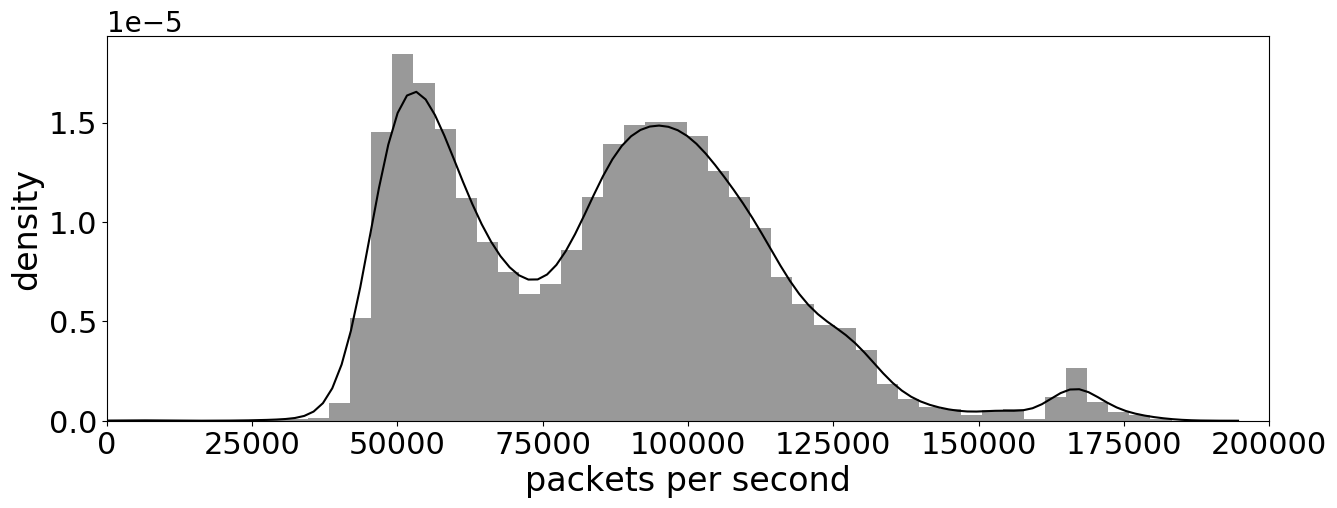

In [31]:
import seaborn as sns
plt.rc('font', size=20)
my_palette = ["black", "grey"]
sns.set_palette(my_palette)
# the hive_row_count.csv is an output of "hive_count_rows_in_tables.py" tha just counts the number of rows/traces in each table uplaoded to Hive
hive_row_count_location = "/home/big-dama/pavol/mawi_feature_extraction/hive_row_count/hive_row_count.csv"
hive_row_count = pd.read_csv(hive_row_count_location)

fig, ax= plt.subplots(1, 1, sharey=True, figsize=(15, 5))
ax = sns.distplot(hive_row_count['row_count'],kde=True)
ax.set_ylabel('density', size=16)
ax.set_xlabel('packets per second',size=16)

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
ax.tick_params(labelsize=22)
ax.set_xlim([0,200000])
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
fig.savefig('plots/mawi_split_size_probability_density.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

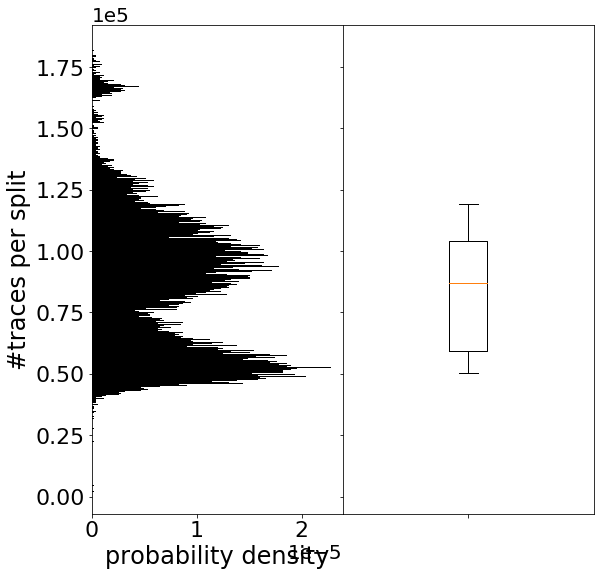

In [3]:
import matplotlib.ticker as mtick
# to change the 1eX label size 
plt.rc('font', size=20)
# the hive_row_count.csv is an output of "hive_count_rows_in_tables.py" tha just counts the number of rows/traces in each table uplaoded to Hive
hive_row_count_location = "/home/big-dama/pavol/mawi_feature_extraction/hive_row_count/hive_row_count.csv"
hive_row_count = pd.read_csv(hive_row_count_location)

fig, [ax1,ax2]= plt.subplots(1, 2, sharey=True, figsize=(9, 9))
fig.subplots_adjust(wspace=0)
#fig.suptitle('MAWI dataset split size probability density', size=20)

ax1.hist(hive_row_count['row_count'], color='black',bins = 1000, density=True,orientation="horizontal")
ax1.set_xlabel('probability density', size=16)
ax1.set_ylabel('#traces per split',size=16)

ax1.xaxis.label.set_size(24)
ax1.yaxis.label.set_size(24)
ax1.tick_params(labelsize=22)
ax2.boxplot(hive_row_count['row_count'], whis=[10,90], showfliers=False,)
ax2.set_xticklabels([''])

ax1.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
#fig.savefig('plots/mawi_split_size_probability_density.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)
plt.rcdefaults()

## Section 3.2 Dataset feature variability
We will show feature variability in the datasets. This information helps us undestand if the features have outlliers and therefore if they are usable for anomaly detection.

In [3]:
# create list of columns for each subplot based on field from which they were extracted - mainly
frame_len_cols = [i for i in mawi_features_052016_pd.columns.values if 'frame_len' in i and 'entropy' not in i and 'vol' not in i and 'num_' not in i]
ip_len_cols = [i for i in mawi_features_052016_pd.columns.values if 'ip_len' in i and 'entropy' not in i]
ip_ttl_cols = [i for i in mawi_features_052016_pd.columns.values if 'ip_ttl' in i and 'entropy' not in i]
# remvoe variance from ip ttl as it seems TTL has more of a categorical nature - not continuously changing numerical values
ip_ttl_cols.remove('var(ip_ttl)')
tcp_len_cols = [i for i in mawi_features_052016_pd.columns.values if 'tcp_len' in i and 'entropy' not in i]
tcp_winsize_cols = [i for i in mawi_features_052016_pd.columns.values if 'tcp_winsize' in i and 'entropy' not in i]
tcp_flags_cols_num = [i for i in mawi_features_052016_pd.columns.values if 'tcp_flags' in i and 'num_' in i]
tcp_flags_cols_frac = [i for i in mawi_features_052016_pd.columns.values if 'tcp_flags' in i and 'frac_' in i]
ipv_cols = [i for i in mawi_features_052016_pd.columns.values if 'ipv' in i]
ip_proto_cols_num = [i for i in mawi_features_052016_pd.columns.values if 'ip_proto' in i and 'num_' in i]
ip_proto_cols_frac = [i for i in mawi_features_052016_pd.columns.values if 'ip_proto' in i and 'frac_' in i]
port_cols_num = [i for i in mawi_features_052016_pd.columns.values if 'port' in i and 'num_' in i]
port_cols_frac = [i for i in mawi_features_052016_pd.columns.values if 'port' in i and 'frac_' in i]
ip_octet_cols = [i for i in mawi_features_052016_pd.columns.values if ('ip_src' in i or 'ip_dst' in i)]
icmp_type_cols_num = [i for i in mawi_features_052016_pd.columns.values if 'icmp_type' in i and 'num_' in i]
icmp_type_cols_frac = [i for i in mawi_features_052016_pd.columns.values if 'icmp_type' in i and 'frac_' in i]
entropy_cols = ['entropy(icmp_type)', 'entropy(tcp_flags)','entropy(frame_len)','entropy(ip_len)','entropy(tcp_len)','entropy(tcp_winsize)','entropy(icmp_type)','entropy(ip_ttl)']
miscelanous_cols = ['frac_frag','num_frag','num_pkts(frame_len)','vol(frame_len)']

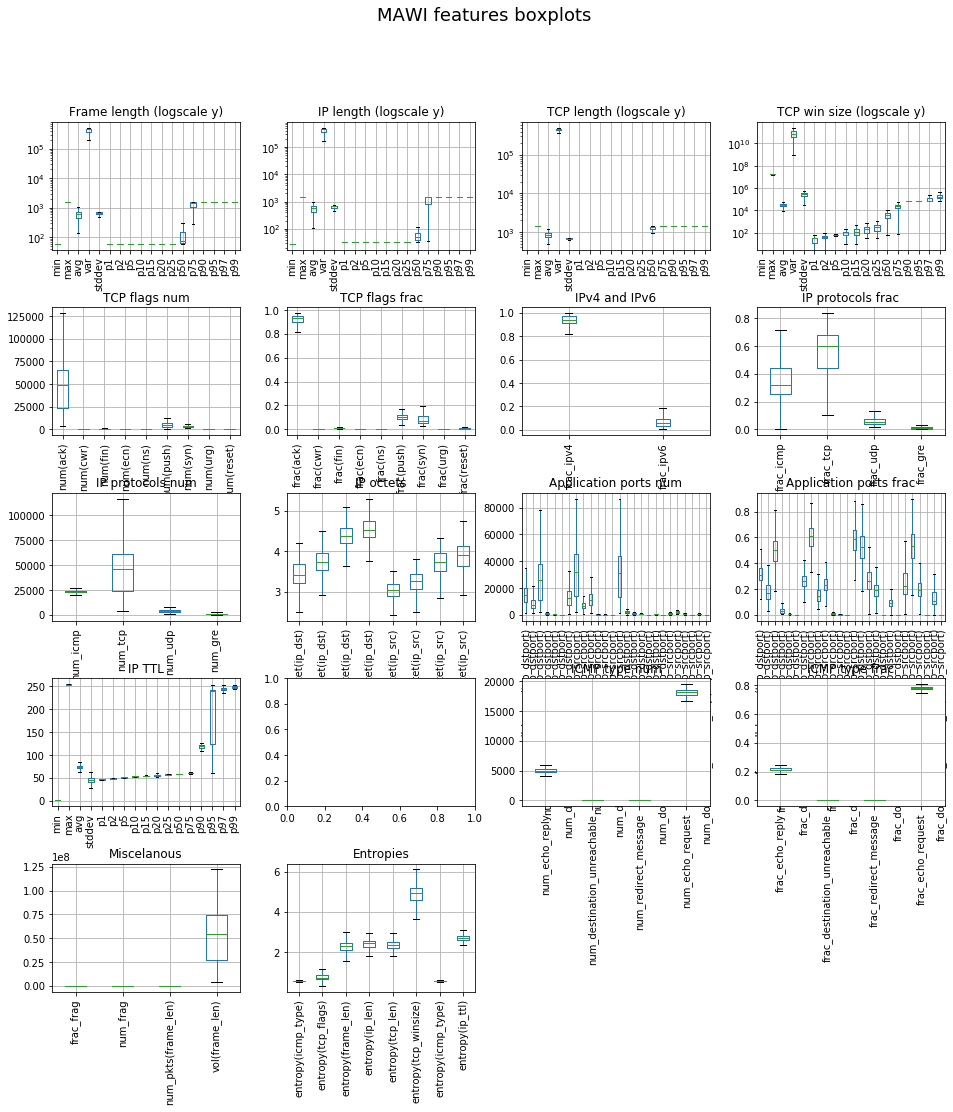

In [12]:
# define dataset we are going to analyze and size of the fig
dataset = mawi_features_052016_pd.copy()
fig, ax = plt.subplots(5, 4, figsize=(16, 16))
fig.suptitle('MAWI features boxplots', fontsize=18)

feature_list_subset = frame_len_cols
# remove additional substrings
feature_list_subset_labels = [x.replace('(frame_len)', '') for x in feature_list_subset]
# 'boxplot = ' is there just so jupyter won't show some 'parameter info' text at the top of the diagram
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[0,0], showfliers = False)
# 'labels' **kwds inside boxplot is not doing anything, we have to specify it manually
ax[0,0].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[0,0].set_title("Frame length (logscale y)")
ax[0,0].semilogy()

feature_list_subset = ip_len_cols
feature_list_subset_labels = [x.replace('(ip_len)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[0,1], showfliers = False)
ax[0,1].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[0,1].set_title("IP length (logscale y)")
ax[0,1].semilogy()

feature_list_subset = tcp_len_cols
feature_list_subset_labels = [x.replace('(tcp_len)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[0,2], showfliers = False)
ax[0,2].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[0,2].set_title("TCP length (logscale y)")
ax[0,2].semilogy()
                              
feature_list_subset = tcp_winsize_cols
feature_list_subset_labels = [x.replace('(tcp_winsize)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[0,3], showfliers = False)
ax[0,3].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[0,3].set_title("TCP win size (logscale y)")
ax[0,3].semilogy()

feature_list_subset = tcp_flags_cols_num
feature_list_subset_labels = [x.replace('(tcp_flags_', '(').replace('(tcp_flags)', '').replace('_tcpflag','') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[1,0], showfliers = False)
ax[1,0].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[1,0].set_title("TCP flags num")

feature_list_subset = tcp_flags_cols_frac
feature_list_subset_labels = [x.replace('(tcp_flags_', '(').replace('(tcp_flags)', '').replace('_tcpflag','') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[1,1], showfliers = False)
ax[1,1].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[1,1].set_title("TCP flags frac")

feature_list_subset = ipv_cols
feature_list_subset_labels = ipv_cols
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[1,2], showfliers = False)
ax[1,2].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[1,2].set_title("IPv4 and IPv6")

feature_list_subset = ip_proto_cols_frac
feature_list_subset_labels = [x.replace('(ip_proto)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[1,3], showfliers = False)
ax[1,3].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[1,3].set_title("IP protocols frac")

feature_list_subset = ip_proto_cols_num
feature_list_subset_labels = [x.replace('(ip_proto)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[2,0], showfliers = False)
ax[2,0].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[2,0].set_title("IP protocols num")

feature_list_subset = ip_octet_cols
feature_list_subset_labels = [x.replace('(ip_octet)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[2,1], showfliers = False)
ax[2,1].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[2,1].set_title("IP octets")

feature_list_subset = port_cols_num
feature_list_subset_labels = feature_list_subset
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[2,2], showfliers = False)
ax[2,2].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[2,2].set_title("Application ports num")

feature_list_subset = port_cols_frac
feature_list_subset_labels = feature_list_subset
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[2,3], showfliers = False)
ax[2,3].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[2,3].set_title("Application ports frac")

feature_list_subset = ip_ttl_cols
feature_list_subset_labels = [x.replace('(ip_ttl)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[3,0], showfliers = False)
ax[3,0].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[3,0].set_title("IP TTL")

feature_list_subset = icmp_type_cols_num
feature_list_subset_labels = [x.replace('(icmp_type)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[3,2], showfliers = False)
ax[3,2].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[3,2].set_title("ICMP type num")

feature_list_subset = icmp_type_cols_frac
feature_list_subset_labels = [x.replace('(icmp_type)', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[3,3], showfliers = False)
ax[3,3].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[3,3].set_title("ICMP type frac")

feature_list_subset = miscelanous_cols
feature_list_subset_labels = [x.replace('', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[4,0], showfliers = False)
ax[4,0].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[4,0].set_title("Miscelanous")

feature_list_subset = entropy_cols
feature_list_subset_labels = [x.replace('', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax[4,1], showfliers = False)
ax[4,1].set_xticklabels(feature_list_subset_labels,rotation='vertical')
ax[4,1].set_title("Entropies")

# remove empty subplots and adjust existing subplots
fig.delaxes(ax[4,2])
fig.delaxes(ax[4,3])
plt.subplots_adjust(hspace = 0.45, wspace = 0.25)

# One-by-one plotting for journal/thesis

/home/big-dama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


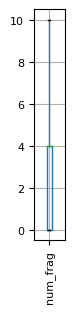

In [31]:
# define dataset we are going to analyze and size of the fig
dataset = mawi_features_052016_pd.copy()
#fig, ax = plt.subplots(1, 1, figsize=(0.4, 3))
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.tick_params(labelsize=8)

# feature_list_subset = frame_len_cols
# # remove additional substrings
# feature_list_subset_labels = [x.replace('(frame_len)', '') for x in feature_list_subset]
# # 'boxplot = ' is there just so jupyter won't show some 'parameter info' text at the top of the diagram
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# # 'labels' **kwds inside boxplot is not doing anything, we have to specify it manually
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("Frame length (logscale y)")
# ax.semilogy()
# fig.savefig('plots/mawi_frame_len_log_scaley.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = ip_len_cols
# feature_list_subset_labels = [x.replace('(ip_len)', '') for x in feature_list_subset]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("IP length (logscale y)")
# ax.semilogy()
# fig.savefig('plots/mawi_ip_len_log_scaley.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = tcp_len_cols
# feature_list_subset_labels = [x.replace('(tcp_len)', '') for x in feature_list_subset]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("TCP length (logscale y)")
# ax.semilogy()
# fig.savefig('plots/mawi_tcp_len_log_scaley.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)
                              
# feature_list_subset = tcp_winsize_cols
# feature_list_subset_labels = [x.replace('(tcp_winsize)', '') for x in feature_list_subset]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("TCP win size (logscale y)")
# ax.semilogy()
# fig.savefig('plots/mawi_tcp_win_size_log_scaley.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = tcp_flags_cols_num
# feature_list_subset_labels = [x.replace('(tcp_flags_', '(').replace('(tcp_flags)', '').replace('_tcpflag','') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace('num(', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace(')', '') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
# #ax.set_title("TCP flags num")
# fig.savefig('plots/mawi_tcp_flag_num.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = tcp_flags_cols_frac
# feature_list_subset_labels = [x.replace('(tcp_flags_', '(').replace('(tcp_flags)', '').replace('_tcpflag','') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace('frac(', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace(')', '') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("TCP flags frac")
# fig.savefig('plots/mawi_tcp_flag_frac.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = ip_proto_cols_frac
# feature_list_subset_labels = [x.replace('(ip_proto)', '') for x in feature_list_subset]
# feature_list_subset = feature_list_subset + ipv_cols 
# feature_list_subset_labels = feature_list_subset_labels + ipv_cols
# feature_list_subset_labels = [x.replace('frac_', '') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("IP protocols frac")
# fig.savefig('plots/mawi_ipv4_vs_ipv6_and_ip_proto_frac.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = ip_proto_cols_num
# feature_list_subset_labels = [x.replace('(ip_proto)', '') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace('num_', '') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
# #ax.set_title("IP protocols num")
# fig.savefig('plots/mawi_ip_proto_num.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = ip_octet_cols
# feature_list_subset_labels = [x.replace('(ip_octet)', '') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace('entropy_', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('ip_', '') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("IP octets")
# fig.savefig('plots/mawi_ip_octets.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = port_cols_num
# #feature_list_subset_labels=feature_list_subset
# feature_list_subset_labels = [x.replace('num_', '') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace('_ports', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('port', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('_udp', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('_tcp', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('document', 'doc') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
# #ax.set_title("Application ports num")
# fig.savefig('plots/mawi_app_port_num.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = port_cols_frac
# # feature_list_subset_labels = feature_list_subset
# feature_list_subset_labels = [x.replace('frac_', '') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace('_ports', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('port', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('_udp', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('_tcp', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('document', 'doc') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("Application ports frac")
# fig.savefig('plots/mawi_app_port_frac.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = ip_ttl_cols
# feature_list_subset_labels = [x.replace('(ip_ttl)', '') for x in feature_list_subset]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("IP TTL")
# fig.savefig('plots/mawi_ip_ttl.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = icmp_type_cols_num
# feature_list_subset_labels = [x.replace('(icmp_type)', '') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace('num_', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('destination_unreachable', 'dest_unreach') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('redirect_message', 'redirect_msg') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
# #ax.set_title("ICMP type num")
# fig.savefig('plots/mawi_icmp_type_num.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = icmp_type_cols_frac
# feature_list_subset_labels = [x.replace('(icmp_type)', '') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace('frac_', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('destination_unreachable', 'dest_unreach') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('redirect_message', 'redirect_msg') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("ICMP type frac")
# fig.savefig('plots/mawi_icmp_type_frac.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)


# plt.rc('font', size=20)
# feature_list_subset = miscelanous_cols[:1]
# feature_list_subset_labels = [x.replace('', '') for x in feature_list_subset]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("Miscelanous")
# ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
# fig.savefig('plots/mawi_frac_frag.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

feature_list_subset = miscelanous_cols[1:2]
feature_list_subset_labels = [x.replace('', '') for x in feature_list_subset]
boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
#ax.set_title("Miscelanous")
fig.savefig('plots/mawi_num_frag.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = miscelanous_cols[2:3]
# feature_list_subset_labels = [x.replace('(frame_len)', '') for x in feature_list_subset]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
# #ax.set_title("Miscelanous")
# fig.savefig('plots/mawi_num_pkts.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = miscelanous_cols[3:]
# feature_list_subset_labels = [x.replace('vol(frame_len)', 'volume') for x in feature_list_subset]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("Miscelanous")
# fig.savefig('plots/mawi_vol.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

# feature_list_subset = entropy_cols
# feature_list_subset_labels = [x.replace('', '') for x in feature_list_subset]
# feature_list_subset_labels = [x.replace(')', '') for x in feature_list_subset_labels]
# feature_list_subset_labels = [x.replace('entropy(', '') for x in feature_list_subset_labels]
# boxplot = dataset.boxplot(column = feature_list_subset, ax = ax, showfliers = False)
# ax.set_xticklabels(feature_list_subset_labels,rotation='vertical')
# #ax.set_title("Entropies")
# fig.savefig('plots/mawi_entropies.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False)

plt.rcdefaults()

# Section 4. Final filtered dataset we are going to use

In [39]:
# all these features were chosen from empirical/visual inspection of boxplots in previous step
# I tried also variance threshold for minmax/robust scaled dataset; feature importance from XBOOST; scikit-feature library - https://github.com/jundongl/scikit-feature
# none of the methods above brought any more meaningfull results
low_variance_features = ['min(frame_len)','max(frame_len)','p1(frame_len)','p2(frame_len)','p5(frame_len)','p10(frame_len)','p15(frame_len)','p20(frame_len)','p25(frame_len)','p90(frame_len)','p95(frame_len)','p97(frame_len)','p99(frame_len)',\
                        'min(ip_len)','max(ip_len)','p1(ip_len)','p2(ip_len)','p5(ip_len)','p10(ip_len)','p15(ip_len)','p20(ip_len)','p25(ip_len)','p90(ip_len)','p95(ip_len)','p97(ip_len)','p99(ip_len)',\
                        'min(tcp_len)','max(tcp_len)','p1(tcp_len)','p2(tcp_len)','p5(tcp_len)','p10(tcp_len)','p15(tcp_len)','p20(tcp_len)','p25(tcp_len)','p75(tcp_len)','p90(tcp_len)','p95(tcp_len)','p97(tcp_len)','p99(tcp_len)',\
                        'min(tcp_winsize)','max(tcp_winsize)','p90(tcp_winsize)','p95(tcp_winsize)',\
                        'min(ip_ttl)','max(ip_ttl)','avg(ip_ttl)','stddev(ip_ttl)','entropy(ip_ttl)','var(ip_ttl)','p1(ip_ttl)','p2(ip_ttl)','p5(ip_ttl)','p10(ip_ttl)','p15(ip_ttl)','p20(ip_ttl)','p25(ip_ttl)','p50(ip_ttl)','p75(ip_ttl)','p90(ip_ttl)','p95(ip_ttl)','p97(ip_ttl)','p99(ip_ttl)',\
                        'num_tcpflag(tcp_flags_cwr)','num_tcpflag(tcp_flags_ecn)','num_tcpflag(tcp_flags_ns)','num_tcpflag(tcp_flags_urg)',\
                        'frac_tcpflag(tcp_flags_cwr)','frac_tcpflag(tcp_flags_ecn)','frac_tcpflag(tcp_flags_ns)','frac_tcpflag(tcp_flags_urg)',\
                        'num_networking_tcp(tcp_dstport)','num_networking_tcp(tcp_srcport)','num_mail_udp(udp_dstport)','num_document_retrieval_udp(udp_dstport)','num_mail_udp(udp_srcport)','num_document_retrieval_udp(udp_srcport)',\
                        'frac_networking_tcp(tcp_dstport)','frac_networking_tcp(tcp_srcport)','frac_mail_udp(udp_dstport)','frac_document_retrieval_udp(udp_dstport)','frac_mail_udp(udp_srcport)','frac_document_retrieval_udp(udp_srcport)',\
                        'table_name','frac_frag', 'num_frag', 'num_destination_unreachable(icmp_type)','num_redirect_message(icmp_type)','frac_tcpflag(tcp_flags_fin)','num_tcpflag(tcp_flags_fin)','num_tcpflag(tcp_flags_reset)','frac_tcpflag(tcp_flags_reset)']
# 101 as it contains 101 columns
mawi_features_052016_pd_standard_scaled_106 = mawi_features_052016_pd_standard_scaled.drop(columns=low_variance_features)
mawi_features_052016_pd_standard_scaled_106.to_csv('/home/big-dama/pavol/mawi_feature_extraction/datasets/mawi_features_052016_standard_scaled_106_thesis.csv', index=False)

## Section 4.1 Correlation of features

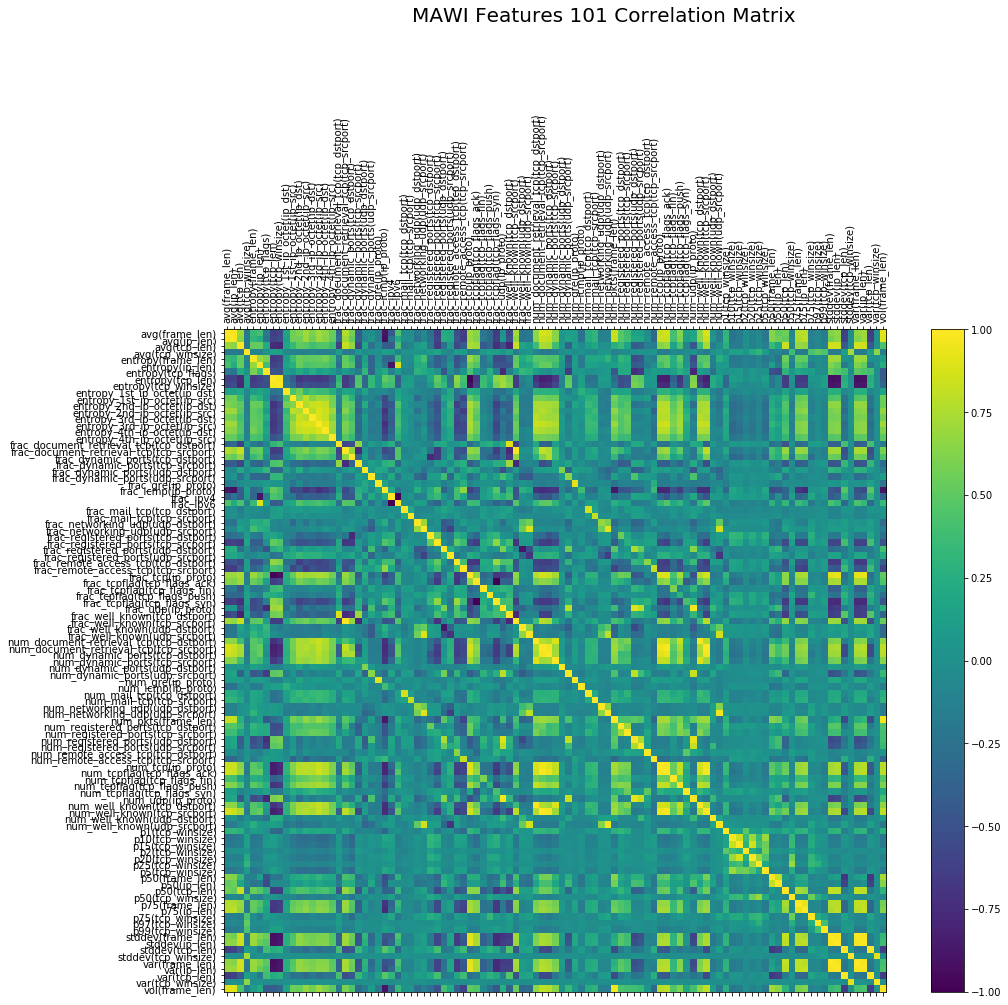

In [2]:
mawi_features_052016_standard_scaled_106_loc = '/home/big-dama/pavol/mawi_feature_extraction/datasetsmawi_features_052016_standard_scaled_106.csv'
mawi_features_052016_pd_standard_scaled_106 = pd.read_csv(mawi_features_052016_standard_scaled_101_loc, index_col=False)

mawi_features_052016_pd_standard_scaled_106_corr = mawi_features_052016_pd_standard_scaled_101.corr()

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
fig.suptitle('MAWI Features 106 Correlation Matrix', size=20)

heatmap = ax.matshow(mawi_features_052016_pd_standard_scaled_101_corr)
ax.set_xticks(range(mawi_features_052016_pd_standard_scaled_101.shape[1]))
ax.set_xticklabels(mawi_features_052016_pd_standard_scaled_101_corr.columns, fontsize=10, rotation=90)
ax.set_yticks(range(mawi_features_052016_pd_standard_scaled_101.shape[1]))
ax.set_yticklabels(mawi_features_052016_pd_standard_scaled_101.columns, fontsize=10)
cb = fig.colorbar(heatmap)
cb.ax.tick_params(labelsize=10)
plt.subplots_adjust(top=0.70)

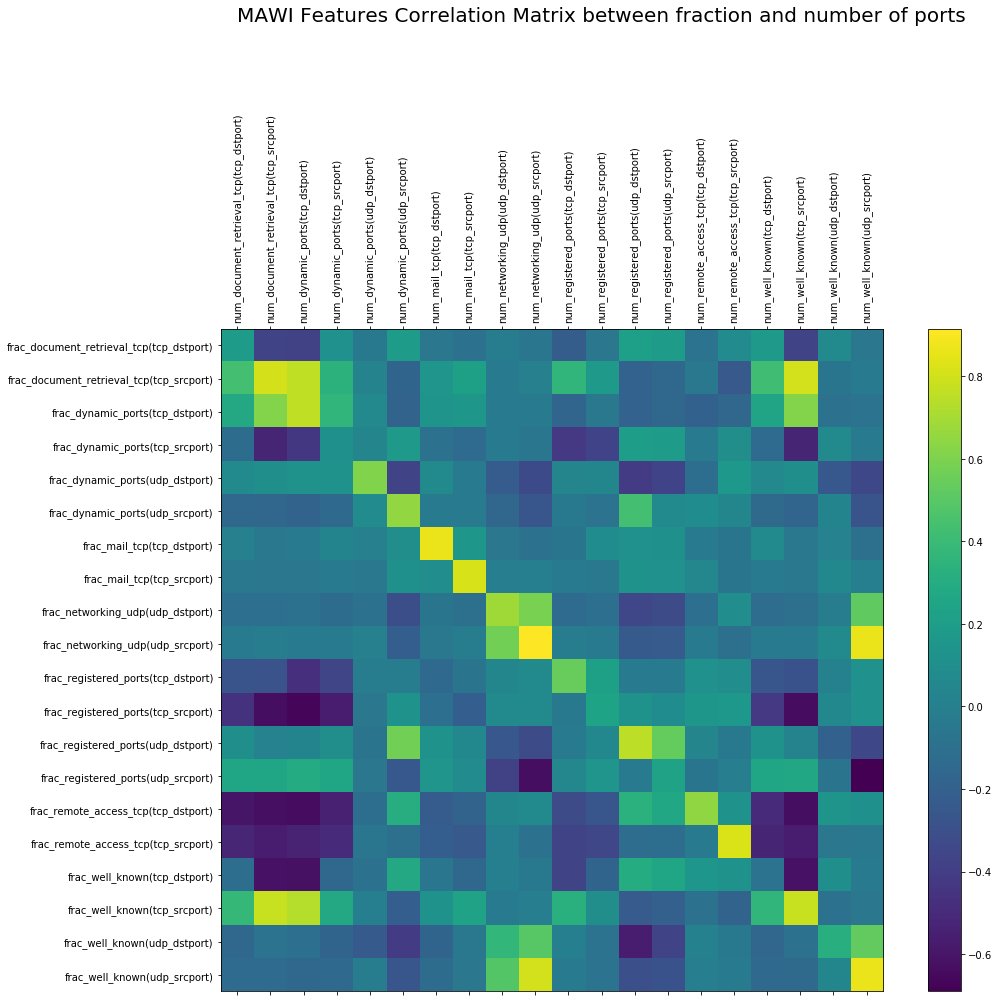

In [48]:
port_columns =  mawi_features_052016_pd_standard_scaled_101_corr.columns[mawi_features_052016_pd_standard_scaled_101_corr.columns.str.contains('port')].values
corr_matrix_whole = mawi_features_052016_pd_standard_scaled_101[port_columns].corr()

corr_matrix = corr_matrix_whole[:20][corr_matrix_whole.columns[corr_matrix_whole.columns.str.contains('num')].values]

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
fig.suptitle('MAWI Features Correlation Matrix between fraction and number of ports', size=20)

heatmap = ax.matshow(corr_matrix)
ax.set_xticks(range(corr_matrix.shape[1]))
ax.set_xticklabels(corr_matrix.columns, fontsize=10, rotation=90)
ax.set_yticks(range(corr_matrix.shape[1]))
ax.set_yticklabels(corr_matrix.index.values, fontsize=10)
cb = fig.colorbar(heatmap)
cb.ax.tick_params(labelsize=10)
plt.subplots_adjust(top=0.70)